# Simulación SIR por partículas — Notebook reproducible

Este cuaderno genera **dos salidas**:
1. Un **GIF** con la animación de partículas coloreadas por estado (S, I, R) con rebotes elásticos.
2. Una **imagen PNG** con las curvas temporales S(t), I(t), R(t), y una **figura compuesta** tipo “panel izquierdo/ panel derecho”.

**Uso:** Ajusta parámetros → ejecuta *Simulación* → ejecuta *Figura compuesta* → ejecuta *Curvas SIR* → ejecuta *GIF*.


### Celda 2 — Imports y RNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display
from pathlib import Path

# Semilla reproducible
rng_seed = 42
rng = np.random.default_rng(rng_seed)

# Carpeta de salidas (local)
out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

### Celda 3 — Parámetros

In [2]:
# Dominio y población
L = 100.0      # lado del cuadrado [0,L]x[0,L]
N = 200        # número de partículas
I0 = 8         # infectados iniciales

# Movimiento
vmax = 1.6     # rapidez máxima (se muestrea en [0.6*vmax, vmax])

# SIR
r = 5.0        # radio de contagio
beta = 0.70   # tasa de infección
gamma = 0.05   # tasa de recuperación

# Integración temporal
dt = 0.5
steps = 260

# Render/export
sample_every = 3        # usar 1 de cada 3 pasos en el GIF (acelera)
gif_fps = 15
png_curvas = out_dir / "sir_curvas.png"
png_compuesto = out_dir / "sir_compuesto.png"
gif_path = out_dir / "sir_particulas.gif"


### Celda 4 — Simulación (con historia completa y frames para GIF)

In [3]:
SUS, INF, REC = 0, 1, 2

# Inicialización
pos = rng.uniform(0, L, size=(N, 2))
angles = rng.uniform(0, 2*np.pi, size=N)
speeds = rng.uniform(0.6*vmax, vmax, size=N)
vel = np.column_stack((np.cos(angles), np.sin(angles))) * speeds[:, None]

states = np.full(N, SUS, dtype=np.int8)
states[rng.choice(N, size=I0, replace=False)] = INF

# Historial para curvas
S_hist = np.zeros(steps, dtype=int)
I_hist = np.zeros(steps, dtype=int)
R_hist = np.zeros(steps, dtype=int)

# Historial completo para figura compuesta
pos_hist = np.zeros((steps, N, 2), dtype=float)
state_hist = np.zeros((steps, N), dtype=np.int8)

# Frames muestreados para GIF
frames_idx = list(range(0, steps, sample_every))
pos_frames = np.zeros((len(frames_idx), N, 2), dtype=float)
state_frames = np.zeros((len(frames_idx), N), dtype=np.int8)

p_recover = 1 - np.exp(-gamma * dt)

fw = 0
for t in range(steps):
    # Registrar historia
    S_hist[t] = np.count_nonzero(states == SUS)
    I_hist[t] = np.count_nonzero(states == INF)
    R_hist[t] = np.count_nonzero(states == REC)
    pos_hist[t] = pos
    state_hist[t] = states

    if t in frames_idx:
        pos_frames[fw] = pos
        state_frames[fw] = states
        fw += 1

    # Movimiento
    pos = pos + vel * dt

    # Rebotes X
    hit_left = pos[:, 0] < 0
    hit_right = pos[:, 0] > L
    pos[hit_left, 0] = -pos[hit_left, 0]
    vel[hit_left, 0] *= -1
    pos[hit_right, 0] = 2*L - pos[hit_right, 0]
    vel[hit_right, 0] *= -1

    # Rebotes Y
    hit_bottom = pos[:, 1] < 0
    hit_top = pos[:, 1] > L
    pos[hit_bottom, 1] = -pos[hit_bottom, 1]
    vel[hit_bottom, 1] *= -1
    pos[hit_top, 1] = 2*L - pos[hit_top, 1]
    vel[hit_top, 1] *= -1

    # Contagios
    sus_idx = np.where(states == SUS)[0]
    inf_idx = np.where(states == INF)[0]
    if sus_idx.size and inf_idx.size:
        sus_pos = pos[sus_idx]
        inf_pos = pos[inf_idx]
        d2 = ((sus_pos[:, None, :] - inf_pos[None, :, :])**2).sum(axis=2)
        n_inf_neighbors = (d2 <= (r*r)).sum(axis=1)
        p_infect = 1 - np.exp(-beta * n_inf_neighbors * dt)
        will_infect = rng.random(size=sus_idx.size) < p_infect
        states[sus_idx[will_infect]] = INF

    # Recuperaciones
    if inf_idx.size:
        will_recover = rng.random(size=inf_idx.size) < p_recover
        states[inf_idx[will_recover]] = REC

time = np.arange(steps) * dt


### Celda 5 — Figura compuesta (snapshot + curvas)

Crea una imagen tipo la que mostraste: izquierda un frame de partículas (en el pico de infectados), derecha las curvas SIR.

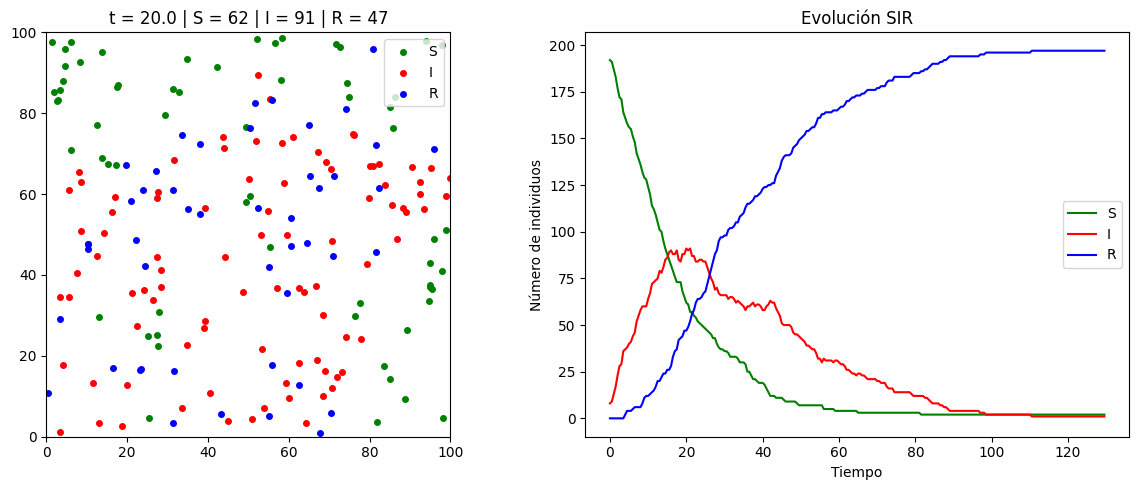

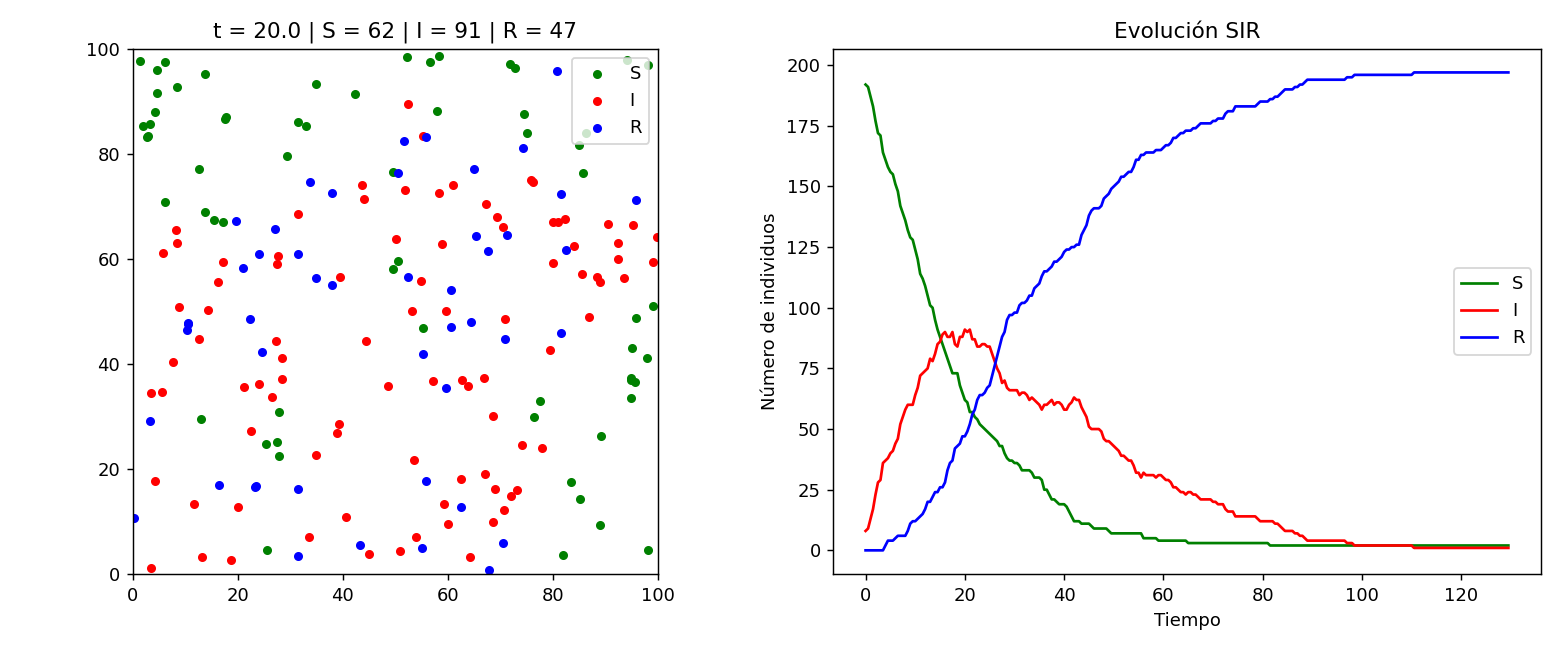

In [4]:
# Elegimos el frame del pico de infectados para la foto del panel izquierdo
frame_to_plot = int(np.argmax(I_hist))
p = pos_hist[frame_to_plot]
st = state_hist[frame_to_plot]

S_pts = p[st == SUS]
I_pts = p[st == INF]
R_pts = p[st == REC]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# Panel izquierdo: snapshot
ax0.set_xlim(0, L); ax0.set_ylim(0, L); ax0.set_aspect('equal')
ax0.scatter(S_pts[:, 0], S_pts[:, 1], s=16, c='g', label='S')
ax0.scatter(I_pts[:, 0], I_pts[:, 1], s=16, c='r', label='I')
ax0.scatter(R_pts[:, 0], R_pts[:, 1], s=16, c='b', label='R')
ax0.legend(loc='upper right')
ax0.set_title(f"t = {time[frame_to_plot]:.1f} | S = {S_hist[frame_to_plot]} | I = {I_hist[frame_to_plot]} | R = {R_hist[frame_to_plot]}")

# Panel derecho: curvas SIR
ax1.plot(time, S_hist, 'g', label='S')
ax1.plot(time, I_hist, 'r', label='I')
ax1.plot(time, R_hist, 'b', label='R')
ax1.set_xlabel('Tiempo'); ax1.set_ylabel('Número de individuos')
ax1.set_title('Evolución SIR'); ax1.legend()

plt.tight_layout()
plt.savefig(png_compuesto, dpi=130)
plt.show()
display(Image(filename=str(png_compuesto)))


### Celda 6 — Curvas SIR (PNG)

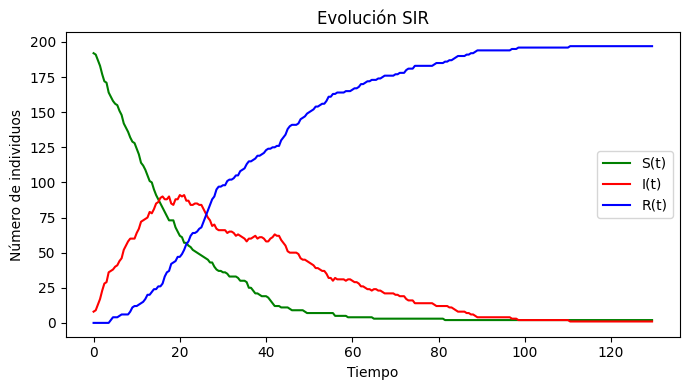

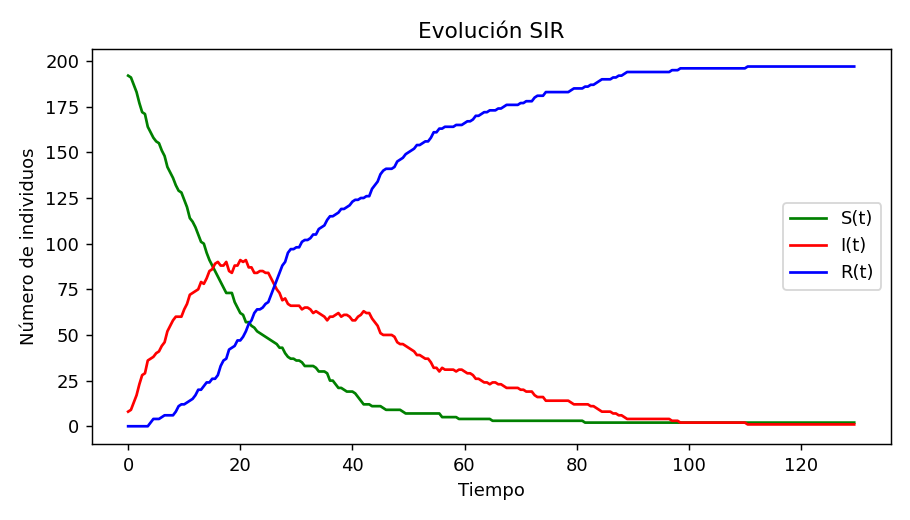

In [5]:
plt.figure(figsize=(7, 4))
plt.plot(time, S_hist, 'g', label='S(t)')
plt.plot(time, I_hist, 'r', label='I(t)')
plt.plot(time, R_hist, 'b', label='R(t)')
plt.xlabel('Tiempo'); plt.ylabel('Número de individuos')
plt.title('Evolución SIR')
plt.legend()
plt.tight_layout()
plt.savefig(png_curvas, dpi=130)
plt.show()
display(Image(filename=str(png_curvas)))


### Celda 7 — GIF (export + display en el notebook)

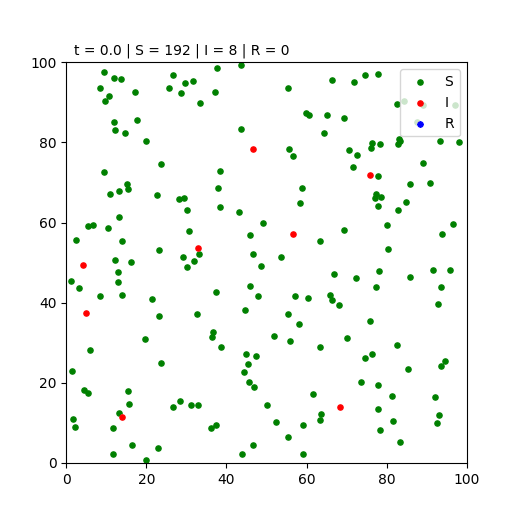

In [6]:
fig, ax = plt.subplots(figsize=(5.2, 5.2))
ax.set_xlim(0, L); ax.set_ylim(0, L); ax.set_aspect('equal')
title_text = ax.text(0.02, 1.02, '', transform=ax.transAxes)

# Objetos de dispersión con colores fijos
scat_S = ax.scatter([], [], s=14, c='g', label='S')
scat_I = ax.scatter([], [], s=14, c='r', label='I')
scat_R = ax.scatter([], [], s=14, c='b', label='R')
ax.legend(loc='upper right')

def init():
    scat_S.set_offsets(np.empty((0, 2)))
    scat_I.set_offsets(np.empty((0, 2)))
    scat_R.set_offsets(np.empty((0, 2)))
    title_text.set_text('')
    return scat_S, scat_I, scat_R, title_text

def update(i):
    p = pos_frames[i]
    st = state_frames[i]
    S_pts = p[st == SUS]; I_pts = p[st == INF]; R_pts = p[st == REC]
    scat_S.set_offsets(S_pts if S_pts.size else np.empty((0, 2)))
    scat_I.set_offsets(I_pts if I_pts.size else np.empty((0, 2)))
    scat_R.set_offsets(R_pts if R_pts.size else np.empty((0, 2)))
    t_now = frames_idx[i] * dt
    title_text.set_text(f't = {t_now:.1f} | S = {S_hist[frames_idx[i]]} | I = {I_hist[frames_idx[i]]} | R = {R_hist[frames_idx[i]]}')
    return scat_S, scat_I, scat_R, title_text

anim = FuncAnimation(fig, update, frames=len(frames_idx), init_func=init, blit=True, interval=33)
anim.save(str(gif_path), writer=PillowWriter(fps=gif_fps))
plt.close(fig)

display(Image(filename=str(gif_path)))
